In [3]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import fio, mtr, viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Now. I want to find and set up the new metric and reason through it on some of these examples
refs, ests = fio.salami_annos(776)
ref1, ref2 = refs.values()
est1, est2, est3 = ests.values()

## Now how do my I define recall between ref_rated_boundaries and est_rated_boundaries?

1) I take all the boundary keys in the ref_rated boundaries, 
2) see how much est_rated_boundary can recover: hit rate, and count inversions of pair ranks.

So we only need to look at all the potential boundaries in ref_rated_boundaries.

In [5]:
import mir_eval, librosa
import numpy as np
from scipy import stats
from collections import Counter

In [7]:
def bmeasure(ref_itvls, est_itvls, window=0.5, beta=1.0, force_mono=False, trim=True, **mono_kwargs):
    # Get the salience
    ref_bs, ref_sal = boundary_salience(ref_itvls, trim=trim, force_mono=force_mono, **mono_kwargs)
    est_bs, est_sal = boundary_salience(est_itvls, trim=trim, force_mono=force_mono, **mono_kwargs)
    
    # Get the salience at the other annotation's boundaries
    est_sal_at_ref_bs = salience_at_bs(ref_bs, est_bs, est_sal, window=window)
    ref_sal_at_est_bs = salience_at_bs(est_bs, ref_bs, ref_sal, window=window)

    print('  computing precision...')
    precision = b_rank_recall(est_sal, ref_sal_at_est_bs)
    print('  computing recall...')
    recall = b_rank_recall(ref_sal, est_sal_at_ref_bs)
    
    f_measure = mir_eval.util.f_measure(recall, precision, beta=beta)
    return precision, recall, f_measure


def boundary_salience(hier_itvls, trim=True, force_mono=False, **mono_kwargs):
    hier = bnl.H(hier_itvls)
    # cast to mono accordingly
    if force_mono and not hier.has_mono_B():
        if force_mono == 'naive':
            config = {'min_seg_dur': 1}
            config.update(mono_kwargs)
            hier = hier.force_mono_B(**config)
        elif force_mono == 'bsc':
            config = {'sr': 10, 'bw': 0.5}
            config.update(mono_kwargs)
            hier = hier.decode_B(**config)

    # use counter to accumulate boundary counts, which in the monotonic case will be salience
    counter = Counter()
    for lvl in hier.levels:
        if trim:
            bs = lvl.beta[1:-1]
        else:
            bs = lvl.beta
        counter.update(bs)
    boundaries, salience = zip(*sorted(counter.items()))
    return np.array(boundaries), np.array(salience)

def salience_at_bs(ref_bs, est_bs, est_sal, window=0.5):
    # Let's do match-event first, and see whether each ref bs of any depth is recalled at all in any level of est:
    hits = mir_eval.util.match_events(ref_bs, est_bs, window=window)
    est_sal_at_ref_bs = np.zeros(len(ref_bs))
    for ref_index, est_index in hits:
        # if it's a hit, get the salience of that boundary in est_sal
        est_sal_at_ref_bs[ref_index] = est_sal[est_index]
    return est_sal_at_ref_bs

def b_rank_recall(ref_sal, est_sal_at_ref_bs):
    # Now we have two lists, let's just count inversions in ranking
    # Caveat is that any salience of 0 comparison will not be included.
    valid_mask = est_sal_at_ref_bs > 0
    hit_recalled = np.count_nonzero(valid_mask)
    total_bs = len(ref_sal)
    
    inversions, total_pairs = mir_eval.hierarchy._compare_frame_rankings(
        ref_sal[valid_mask], est_sal_at_ref_bs[valid_mask], transitive=True
    )
    hit_recall = hit_recalled / total_bs if total_bs > 0 else 1.0
    rank_recall = (total_pairs - inversions) / total_pairs if total_pairs > 0 else np.nan

    print(f"\t hit:  {hit_recall:.4f}, {hit_recalled:.0f}, {total_bs:.0f}")
    print(f"\t rank: {rank_recall:.4f}, {total_pairs - inversions:.0f}, {total_pairs:.0f}")

    return mir_eval.util.f_measure(hit_recall, rank_recall, beta=1.0) if rank_recall > 0.0 else hit_recall


## Look at flat against flat:

In [8]:
flat_ref = ref1.levels[1]
flat_est = ref2.levels[1]
window=0.5

print('hit rate:', mir_eval.segment.detection(flat_ref.itvls, flat_est.itvls, trim=True))
print('bmeasure:', bmeasure([flat_ref.itvls], [flat_est.itvls]))

hit rate: (0.49019607843137253, 1.0, 0.6578947368421052)
  computing precision...
	 hit:  0.4902, 25, 51
	 rank: nan, 0, 0
  computing recall...
	 hit:  1.0000, 25, 25
	 rank: nan, 0, 0
bmeasure: (0.49019607843137253, 1.0, 0.6578947368421052)


In [9]:
print(bmeasure(ref1.itvls, ref2.itvls))
print(mir_eval.hierarchy.tmeasure(ref1.itvls, ref2.itvls, transitive=True))

  computing precision...
	 hit:  0.4902, 25, 51
	 rank: 0.5000, 77, 154
  computing recall...
	 hit:  1.0000, 25, 25
	 rank: 0.6111, 77, 126
(0.495049504950495, 0.7586206896551725, 0.599128540305011)
(0.7223163033960046, 0.7593344878163061, 0.7403629566880571)


In [16]:
bnl.mtr.bmeasure(ref1.itvls, ref2.itvls)

(0.495049504950495, 0.7586206896551725, 0.599128540305011)

In [115]:
print(bmeasure(ref2.itvls, est2.itvls))
print(mir_eval.hierarchy.tmeasure(ref2.itvls, est2.itvls, transitive=True))

  computing precision...
	 hit:  0.5556, 10, 18
	 rank: 0.1951, 8, 41
  computing recall...
	 hit:  0.1961, 10, 51
	 rank: 0.8889, 8, 9
(0.28880866425992785, 0.321285140562249, 0.3041825095057034)


/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 3
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 4
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 5
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 6
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 7
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 8
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib

(0.711745306493481, 0.48499245668430124, 0.576886792329815)


In [ ]:
print(bmeasure(ref2.itvls, est2.itvls, force_mono='naive'))
print(mir_eval.hierarchy.tmeasure(ref2.itvls, est2.itvls, transitive=True))


  computing precision...
	 hit:  0.6923, 9, 13
	 rank: 0.2500, 8, 32
  computing recall...
	 hit:  0.1765, 9, 51
	 rank: 1.0000, 8, 8
(0.3673469387755102, 0.3, 0.3302752293577982)


/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 3
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 4
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 5
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 6
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 7
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/mir_eval/hierarchy.py:460: UserWarning: Segment hierarchy is inconsistent at level 8
  warnings.warn(
/Users/xi/miniforge3/envs/py39/lib

(0.2819605827898454, 0.459197510973634, 0.34938726001713455)


In [107]:
bmeasure(ref2.itvls, est2.itvls, window=0.5, beta=1.0, force_mono='bsc', bw=0.5, sr=10)

  computing precision...
	 hit:  0.8182, 9, 11
	 rank: 0.2222, 8, 36
  computing recall...
	 hit:  0.1765, 9, 51
	 rank: 1.0000, 8, 8


(0.34951456310679613, 0.3, 0.32286995515695066)

In [111]:
bmeasure(ref2.itvls, est2.itvls, window=0.5, beta=1.0, force_mono='bsc', bw=0.5, sr=10, depth=4)

  computing precision...
	 hit:  0.8182, 9, 11
	 rank: 0.2500, 7, 28
  computing recall...
	 hit:  0.1765, 9, 51
	 rank: 0.8750, 7, 8


(0.38297872340425526, 0.2937062937062937, 0.33245382585751976)

In [108]:
bmeasure(ref2.itvls, est2.itvls, window=0.5, beta=1.0, force_mono='bsc', bw=0.5, sr=10, depth=2)

  computing precision...
	 hit:  0.8182, 9, 11
	 rank: 0.5000, 7, 14
  computing recall...
	 hit:  0.1765, 9, 51
	 rank: 0.8750, 7, 8


(0.6206896551724137, 0.2937062937062937, 0.39873417721518983)

## Let's build a d_ref by d_est table, and get all their scores

In [68]:
import xarray as xr

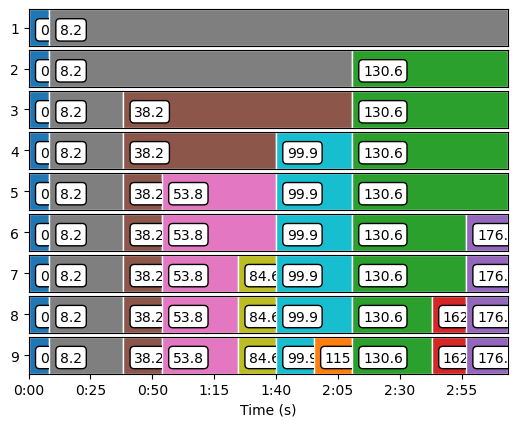

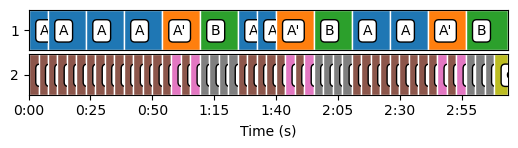

In [72]:
import itertools
ref = refs['6']
est = ests['mu5_gamma5']
coords = dict(d_ref = list(range(ref.d)), d_est = list(range(est.d)), score=['p','r','f'])

# fixed_est = est.force_mono_B(min_seg_dur=1)
fixed_est = est.decode_B(sr=10, bw=1)
fixed_est.plot()
ref.plot()

# Collect results
coords = dict(d_ref = list(range(ref.d)), d_est = list(range(fixed_est.d)), score=['p','r','f'])
result = xr.DataArray(coords=coords, dims=coords.keys())

result = xr.DataArray(coords=coords, dims=coords.keys())
for r_lvl, e_lvl in itertools.product(range(ref.d), range(fixed_est.d)):

    result.loc[dict(d_ref=r_lvl, d_est=e_lvl, score=slice(None))] = np.array(
        mir_eval.segment.detection(ref.itvls[r_lvl], fixed_est.itvls[e_lvl])
    )

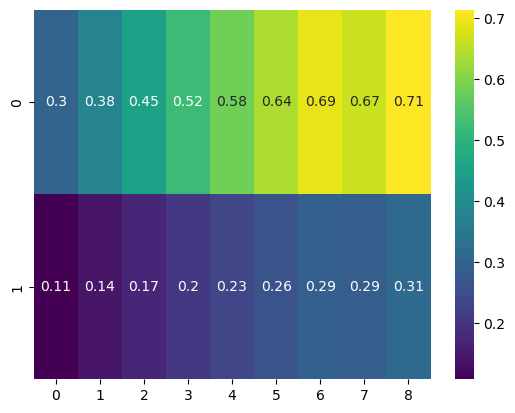

In [73]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Plot using seaborn heatmap.
# Use .values to convert the DataArray slice to a NumPy array.

for s in ['f']:
    da_slice = result.sel(score=s)
    sns.heatmap(da_slice.values, annot=True, cmap='viridis',
                xticklabels=da_slice.d_est.values,
                yticklabels=da_slice.d_ref.values)
    plt.show()
    

In [ ]:
## Now I have a stable implementation that works as expected. I need to compare it with t-measure